In [105]:
!pip install imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import datetime as dt
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier


In [85]:
# load all csv files into respective dataframes

#The Target, and Actual Rate that Federal Banks charge each other for over night Loans
FR_target_pt1_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\DFEDTARU_pt1.csv')
FR_target_pt2_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\DFEDTAR_pt2.csv')

FF_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\FF.csv')


#FOREX rates 
AUD_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\DEXUSAL.csv')
EUR_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\EXUSEU.csv')
GBP_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\DEXUSUK.csv')
JPY_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\DEXJPUS.csv')


#Important commodities that help determine interest rates
OIL_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\DCOILBRENTEU (1).csv')


#Treasuries are benchmarks for performance of financial instruments
T10YR_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\WGS10YR.csv')
T3M_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\TB3MS.csv')


#Economic features like GDP, Natural Unemployment Rate, Personal Consumption Expenditures
GDP_df = pd.read_csv(r'..\\Project_2_BTC_Price_Modeling\csv_files\GDPC1.csv')
NAT_UNEMPLOYMENT_df = pd.read_csv(r'..\\Project_2_BTC_Price_Modeling\csv_files\NROU.csv')
PCE_df = pd.read_csv('..\\Project_2_BTC_Price_Modeling\csv_files\PCE.csv')





In [4]:
#Euro exchange is in monthly units. Calendarize to weekly, and repeat the percent change for each week in the month

EUR_df.head()

EUR_df.rename(columns={'DATE':'Date'},inplace=True)
EUR_df["Date"] = pd.to_datetime(EUR_df['Date'])

#Generate weekly date range from the start to the end of the DataFrame
weekly_dates = pd.date_range(start=EUR_df['Date'].min(), end=EUR_df['Date'].max(), freq='W')

# Step 2: Create a new DataFrame with these weekly dates
df_weekly = pd.DataFrame({'Date': weekly_dates})

#Use merge_asof to align the monthly values to the weekly dates
EUR_df = pd.merge_asof(df_weekly, EUR_df, on='Date', direction='backward')

#Shift 4 days back to align every dataframe on the same date
EUR_df['Date'] = EUR_df['Date'] - pd.Timedelta(days=4)

EUR_df.head(20)

,Date,EXUSEU_PCH
0,2004-09-01,0.27069
1,2004-09-08,0.27069
2,2004-09-15,0.27069
3,2004-09-22,0.27069
4,2004-09-29,2.31512
5,2004-10-06,2.31512
6,2004-10-13,2.31512
7,2004-10-20,2.31512
8,2004-10-27,2.31512
9,2004-11-03,3.91781


In [5]:
#shift date column for 10YR Treasury percent change 5 days ahead, so that it will match other dataframes

T10YR_df.rename(columns={'DATE':'Date'}, inplace=True)

T10YR_df['Date'] = pd.to_datetime(T10YR_df['Date'])

T10YR_df['Date'] = T10YR_df['Date'] + pd.Timedelta(days=5)

T10YR_df.head()


,Date,WGS10YR_PCH
0,2004-09-01,0.47281
1,2004-09-08,-1.41176
2,2004-09-15,0.47733
3,2004-09-22,-1.66271
4,2004-09-29,-2.41546


In [6]:
#Rename Dataframes
OIL_df.rename(columns={"DATE":"Date","DCOILBRENTEU_PCH":"Price_of_Barrel (Percent Change)"},inplace=True)
OIL_df.head()

,Date,Price_of_Barrel (Percent Change)
0,2004-09-01,-7.79752
1,2004-09-08,0.51747
2,2004-09-15,1.23554
3,2004-09-22,5.37582
4,2004-09-29,7.35821


In [7]:
T3M_df.rename(columns={'DATE':'Date'}, inplace=True)
T3M_df["Date"] = pd.to_datetime(T3M_df['Date'])

#Generate weekly date range from the start to the end of the DataFrame
weekly_dates = pd.date_range(start=T3M_df['Date'].min(), end=T3M_df['Date'].max(), freq='W')

# Create a new DataFrame with these weekly dates
df_weekly = pd.DataFrame({'Date': weekly_dates})

#Use merge_asof to align the monthly values to the weekly dates
T3M_df = pd.merge_asof(df_weekly, T3M_df, on='Date', direction='backward')

T3M_df['Date'] = T3M_df['Date'] - pd.Timedelta(days=4)

T3M_df.head()

,Date,TB3MS_PCH
0,2004-09-01,11.48649
1,2004-09-08,11.48649
2,2004-09-15,11.48649
3,2004-09-22,11.48649
4,2004-09-29,6.66667


In [8]:
#Add the missing date, 2008-12-14 and interst value change of 0 (filling missing data) to dataframe
FR_target_pt2_df.loc[225] = ['2008-12-24', '0.0']

FR_target_pt2_df.tail()

,DATE,DFEDTAR_CHG
221,2008-11-26,0.0
222,2008-12-03,0.0
223,2008-12-10,0.0
224,2008-12-17,0.0
225,2008-12-24,0.0


In [9]:
#rename target variable pt1 to match pt2 and combine

FR_target_pt1_df.rename(columns={'DATE':'Date','DFEDTARU_CHG' : 'DFEDTAR_CHG'}, inplace=True)
FR_target_pt2_df.rename(columns={'DATE':'Date'}, inplace=True)
FR_target_df = pd.concat([FR_target_pt2_df,FR_target_pt1_df], ignore_index=True)
FR_target_df['Date'] = pd.to_datetime(FR_target_df['Date'])
display(FR_target_df.head())
display(FR_target_df.tail())



,Date,DFEDTAR_CHG
0,2004-09-01,0.0
1,2004-09-08,0.0
2,2004-09-15,0.0
3,2004-09-22,0.071429
4,2004-09-29,0.178571


,Date,DFEDTAR_CHG
1040,2024-08-07,0.0
1041,2024-08-14,0.0
1042,2024-08-21,0.0
1043,2024-08-28,0.0
1044,2024-09-04,0.0


In [10]:
FF_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    1045 non-null   object 
 1   FF_CHG  1045 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.5+ KB


In [11]:
FF_df['DATE'] = pd.to_datetime(FF_df['DATE'])
FF_df = FF_df.rename(columns={"DATE":"Date"})


In [12]:
FF_df.head()

,Date,FF_CHG
0,2004-09-01,0.02
1,2004-09-08,-0.03
2,2004-09-15,-0.01
3,2004-09-22,0.15
4,2004-09-29,0.12


<Axes: >

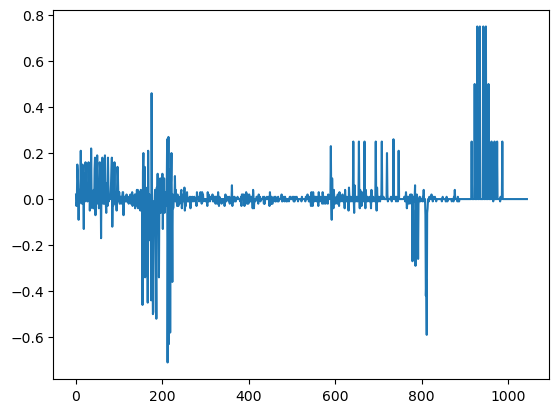

In [13]:
FF_df['FF_CHG'].plot(x='Date')

In [14]:
FF_df.columns = ['ds','y']


In [15]:
display(FF_df.shape)
display(FF_df.head(10))
display(FF_df.tail(10))

(1045, 2)

,ds,y
0,2004-09-01,0.02
1,2004-09-08,-0.03
2,2004-09-15,-0.01
3,2004-09-22,0.15
4,2004-09-29,0.12
5,2004-10-06,0.06
6,2004-10-13,-0.09
7,2004-10-20,0.03
8,2004-10-27,-0.02
9,2004-11-03,0.04


,ds,y
1035,2024-07-03,0.0
1036,2024-07-10,0.0
1037,2024-07-17,0.0
1038,2024-07-24,0.0
1039,2024-07-31,0.0
1040,2024-08-07,0.0
1041,2024-08-14,0.0
1042,2024-08-21,0.0
1043,2024-08-28,0.0
1044,2024-09-04,0.0


In [16]:
#check na values

FF_df.isna().value_counts()

ds     y    
False  False    1045
Name: count, dtype: int64

In [17]:
#Instantiate a Prophet model
model = Prophet()
model

In [18]:
#Fit the prophet model to BTC_close_df
model.fit(FF_df)

23:57:01 - cmdstanpy - INFO - Chain [1] start processing
23:57:01 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as  52 weeeks (1 year)
future_trends = model.make_future_dataframe(periods=52, freq="W")

# View the last five rows of the predictions
future_trends.tail()

,ds
1092,2025-08-03
1093,2025-08-10
1094,2025-08-17
1095,2025-08-24
1096,2025-08-31


In [20]:
# Make the predictions for the trend data using the future_trends DataFrame
forecast_trends = model.predict(future_trends)

# Display the first five rows of the forecast DataFrame
forecast_trends.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1092,2025-08-03,0.022374,-0.088049,0.151606,0.022113,0.022674,0.013569,0.013569,0.013569,0.013569,0.013569,0.013569,0.0,0.0,0.0,0.035943
1093,2025-08-10,0.022414,-0.100501,0.145091,0.022137,0.022732,0.002201,0.002201,0.002201,0.002201,0.002201,0.002201,0.0,0.0,0.0,0.024616
1094,2025-08-17,0.022455,-0.103416,0.134468,0.022161,0.022785,-0.007564,-0.007564,-0.007564,-0.007564,-0.007564,-0.007564,0.0,0.0,0.0,0.014891
1095,2025-08-24,0.022495,-0.094729,0.129817,0.022190,0.022838,-0.007742,-0.007742,-0.007742,-0.007742,-0.007742,-0.007742,0.0,0.0,0.0,0.014754
1096,2025-08-31,0.022536,-0.098852,0.136232,0.022221,0.022890,-0.002438,-0.002438,-0.002438,-0.002438,-0.002438,-0.002438,0.0,0.0,0.0,0.020098


c:\Users\dyllan\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\dyllan\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


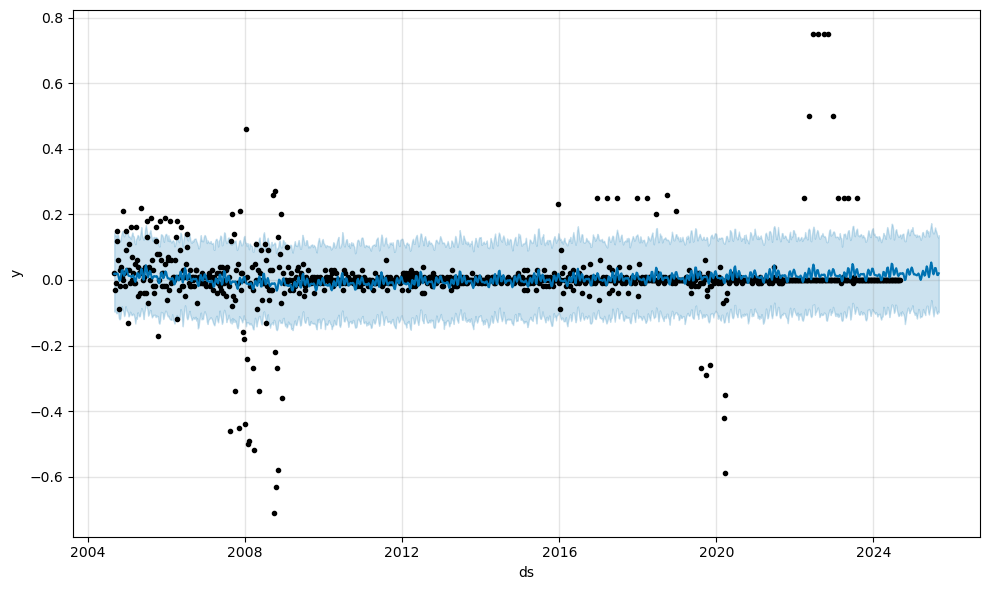

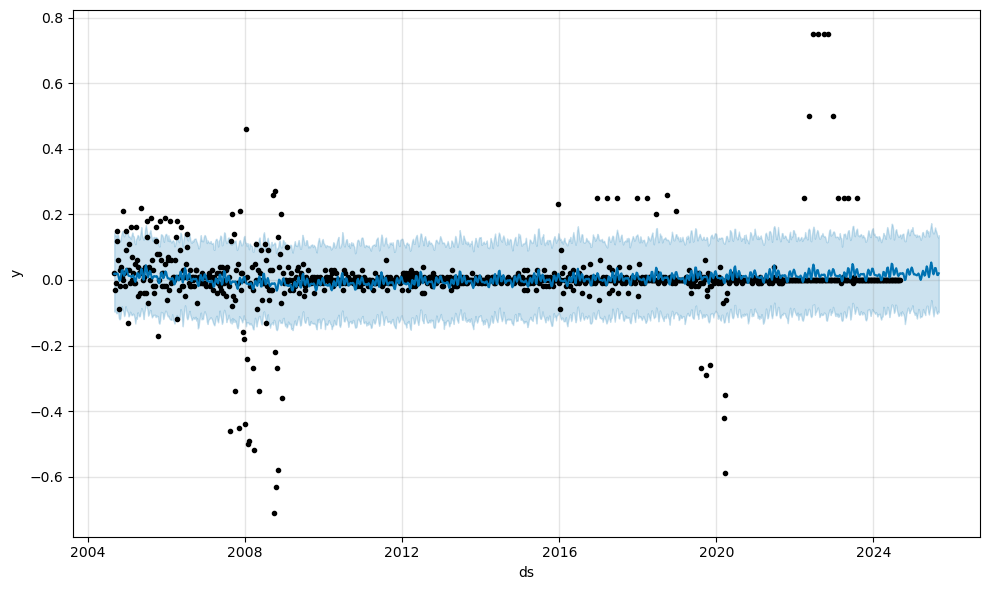

In [21]:
model.plot(forecast_trends)

c:\Users\dyllan\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\dyllan\anaconda3\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\dyllan\anaconda3\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call 

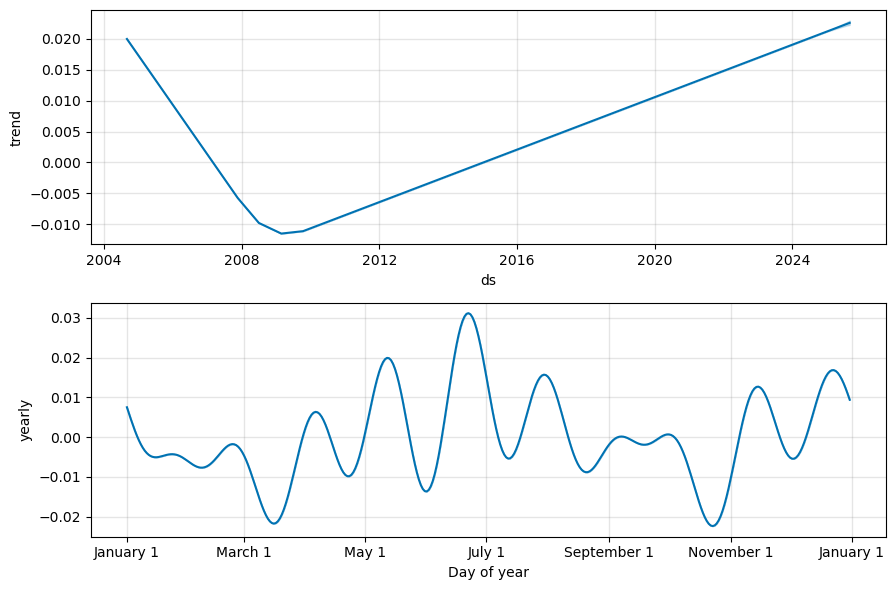

In [22]:
figures = model.plot_components(forecast_trends)

In [23]:
# At this point, it's useful to set the `datetime` index of the forecast data.
forecast_trends = forecast_trends.set_index(["ds"])
forecast_trends.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2004-09-01,0.019934,-0.096427,0.143821,0.019934,0.019934,-0.001612,-0.001612,-0.001612,-0.001612,-0.001612,-0.001612,0.0,0.0,0.0,0.018323
2004-09-08,0.019781,-0.093773,0.135784,0.019781,0.019781,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.0,0.0,0.0,0.019865
2004-09-15,0.019628,-0.097544,0.137424,0.019628,0.019628,-0.001551,-0.001551,-0.001551,-0.001551,-0.001551,-0.001551,0.0,0.0,0.0,0.018077
2004-09-22,0.019475,-0.102049,0.130617,0.019475,0.019475,-0.001422,-0.001422,-0.001422,-0.001422,-0.001422,-0.001422,0.0,0.0,0.0,0.018054
2004-09-29,0.019322,-0.099832,0.137713,0.019322,0.019322,0.000597,0.000597,0.000597,0.000597,0.000597,0.000597,0.0,0.0,0.0,0.019920


<Axes: xlabel='ds'>

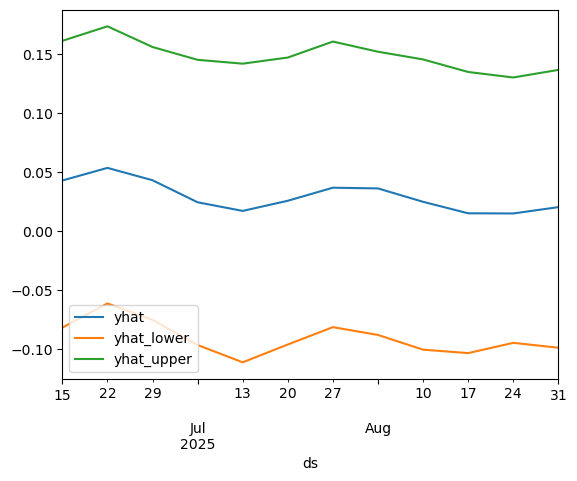

In [24]:
# From the `forecast_trends` DataFrame, plot to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 12 weeks  
forecast_trends[["yhat", "yhat_lower", "yhat_upper"]].iloc[-12:, :].plot()

In [25]:
forecast_Nov_2024 = forecast_trends.loc["2024-11-01":"2024-11-30"][["yhat_upper", "yhat_lower", "yhat"]]

# Replace the column names to something less technical sounding
forecast_Nov_2024 = forecast_Nov_2024.rename(
    columns={
        "yhat_upper": "Best Case",
        "yhat_lower": "Worst Case", 
        "yhat": "Most Likely Case"
    }
)

# Review the last five rows of the DataFrame
forecast_Nov_2024.tail()

,Best Case,Worst Case,Most Likely Case
ds,,,
2024-11-03,0.137490,-0.102115,0.015600
2024-11-10,0.146810,-0.092514,0.030363
2024-11-17,0.155342,-0.084443,0.032625
2024-11-24,0.141406,-0.090312,0.023301


In [26]:
forecast_Nov_2024.mean()

Best Case           0.145262
Worst Case         -0.092346
Most Likely Case    0.025472
dtype: float64

In [27]:

#Create return rate columns for FOREX, rename columns to specify currency, and set date column to date time.

AUD_rename_df = AUD_df.rename(columns={'DATE': 'Date','DEXUSAL_PCH':'AUD_EX_rate (percent change)'})
EUR_rename_df = EUR_df.rename(columns={'DATE': 'Date','EXUSEU_PCH':'EUR_EX_rate (percent change)'})
GBP_rename_df = GBP_df.rename(columns={'DATE': 'Date','DEXUSUK_PCH':'GBP_EX_rate (percent change)'})
JPY_rename_df = JPY_df.rename(columns={'DATE': 'Date','DEXJPUS_PCH':'JPY_EX_rate (percent change)'})

AUD_rename_df['Date'] = pd.to_datetime(AUD_rename_df['Date'])
EUR_rename_df['Date'] = pd.to_datetime(EUR_rename_df['Date'])
GBP_rename_df['Date'] = pd.to_datetime(GBP_rename_df['Date'])
JPY_rename_df['Date'] = pd.to_datetime(JPY_rename_df['Date'])




In [28]:
#Combine treasury bills dataframe, and divide by 100 to reduce to decimals instead of percentages
combined_treasuries_df = T10YR_df.merge(T3M_df, on='Date',how='outer')
combined_treasuries_df['Date'] = pd.to_datetime(combined_treasuries_df['Date'])
combined_treasuries_df['WGS10YR_PCH'] = combined_treasuries_df['WGS10YR_PCH']/100
combined_treasuries_df['TB3MS_PCH'] = combined_treasuries_df['TB3MS_PCH']/100




In [29]:
#Merge FOREX data frames

combined_currency_ex_df = AUD_rename_df.merge(EUR_rename_df, on='Date', how='outer').merge(GBP_rename_df, on='Date', how='outer').merge(JPY_rename_df, on='Date', how='outer')

combined_currency_ex_df.head()


,Date,AUD_EX_rate (percent change),EUR_EX_rate (percent change),GBP_EX_rate (percent change),JPY_EX_rate (percent change)
0,2004-09-01,-1.76296,0.27069,-0.89766,-0.08027
1,2004-09-08,-1.32889,0.27069,-0.71694,0.08444
2,2004-09-15,0.25437,0.27069,0.50330,0.13272
3,2004-09-22,0.77339,0.27069,0.04913,0.21316
4,2004-09-29,1.90579,2.31512,0.64729,0.82900


In [30]:
#Clean GDP dataframe

GDP_df.rename(columns={'DATE':'Date','GDPC1_PCH':'GDP (Percent Change)'},inplace=True)
GDP_df['Date'] = pd.to_datetime(GDP_df['Date'])

# Generate Weekly Date Range for the whole year
weekly_dates = pd.date_range(start='2004-09-01', end='2024-04-30', freq='W-WED')  # Weekly on Wednesdays
weekly_df = pd.DataFrame({'Date': weekly_dates})

# Assign Quarterly Values to Weekly Dates
# Use merge_asof to assign each weekly date to the corresponding quarter's value
GDP_df = pd.merge_asof(weekly_df, GDP_df, on= 'Date', direction='backward')

GDP_df.head()


,Date,GDP (Percent Change)
0,2004-09-01,0.94859
1,2004-09-08,0.94859
2,2004-09-15,0.94859
3,2004-09-22,0.94859
4,2004-09-29,0.94859


In [31]:
#Clean Natural Unemployment dataframe

NAT_UNEMPLOYMENT_df.rename(columns={'DATE':'Date','NROU_PCH':'Natural_UE_rate (Percent Change)'},inplace=True)
NAT_UNEMPLOYMENT_df['Date'] = pd.to_datetime(NAT_UNEMPLOYMENT_df['Date'])

# Generate Weekly Date Range for the whole year
weekly_dates = pd.date_range(start='2004-09-01', end='2024-04-30', freq='W-WED')  # Weekly on Wednesdays
weekly_df = pd.DataFrame({'Date': weekly_dates})

# Assign Quarterly Values to Weekly Dates
# Use merge_asof to assign each weekly date to the corresponding quarter's value
NAT_UNEMPLOYMENT_df = pd.merge_asof(weekly_df, NAT_UNEMPLOYMENT_df, on= 'Date', direction='backward')

NAT_UNEMPLOYMENT_df.head()

,Date,Natural_UE_rate (Percent Change)
0,2004-09-01,-0.18672
1,2004-09-08,-0.18672
2,2004-09-15,-0.18672
3,2004-09-22,-0.18672
4,2004-09-29,-0.18672


In [32]:
#Clean PCE dataframe
PCE_df.rename(columns={'DATE':'Date','PCE_PCH':'PCE (Percent Change)'}, inplace=True)
PCE_df["Date"] = pd.to_datetime(PCE_df['Date'])

#Generate weekly date range from the start to the end of the DataFrame
weekly_dates = pd.date_range(start=PCE_df['Date'].min(), end=PCE_df['Date'].max(), freq='W')

# Create a new DataFrame with these weekly dates
df_weekly = pd.DataFrame({'Date': weekly_dates})

#Use merge_asof to align the monthly values to the weekly dates
PCE_df = pd.merge_asof(df_weekly, PCE_df, on='Date', direction='backward')

PCE_df['Date'] = PCE_df['Date'] - pd.Timedelta(days=4)
PCE_df.head()

,Date,PCE (Percent Change)
0,2004-09-01,0.84506
1,2004-09-08,0.84506
2,2004-09-15,0.84506
3,2004-09-22,0.84506
4,2004-09-29,0.66655


In [33]:
#Combine Economic Features Dataframes
economic_df = GDP_df.merge(PCE_df, on='Date',how='outer').merge(NAT_UNEMPLOYMENT_df, on='Date',how='outer')

In [86]:
FF_df.head()

,DATE,FF_CHG
0,2004-09-01,0.02
1,2004-09-08,-0.03
2,2004-09-15,-0.01
3,2004-09-22,0.15
4,2004-09-29,0.12


In [87]:
FF_df['DATE'] = pd.to_datetime(FF_df['DATE'])
FF_df = FF_df.rename(columns={"DATE":"Date"})

In [88]:
#combine ALL dataframes
combo_df = FF_df.merge(economic_df, on='Date',how='outer').merge(combined_currency_ex_df, on='Date',how='outer').merge(combined_treasuries_df, on='Date',how='outer')
combo_df.rename(columns={'DFEDTAR_CHG':'Federal_Fund_Target_Rate Change', 'WGS10YR_PCH':'10YR_Treasury_Yield (Percent Change)','TB3MS_PCH':'3M_Treasury_Yield (Percent Change)'},inplace=True)

In [89]:
#Clean NA values

combo_clean_df = combo_df.dropna()
combo_clean_df.isna()



,Date,FF_CHG,GDP (Percent Change),PCE (Percent Change),Natural_UE_rate (Percent Change),AUD_EX_rate (percent change),EUR_EX_rate (percent change),GBP_EX_rate (percent change),JPY_EX_rate (percent change),10YR_Treasury_Yield (Percent Change),3M_Treasury_Yield (Percent Change)
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1021,False,False,False,False,False,False,False,False,False,False,False
1022,False,False,False,False,False,False,False,False,False,False,False
1023,False,False,False,False,False,False,False,False,False,False,False
1024,False,False,False,False,False,False,False,False,False,False,False


In [93]:
#check datatypes of each columns

combo_clean_df.dtypes

Date                                    datetime64[ns]
FF_CHG                                         float64
GDP (Percent Change)                           float64
PCE (Percent Change)                           float64
Natural_UE_rate (Percent Change)               float64
AUD_EX_rate (percent change)                    object
EUR_EX_rate (percent change)                   float64
GBP_EX_rate (percent change)                   float64
JPY_EX_rate (percent change)                    object
10YR_Treasury_Yield (Percent Change)           float64
3M_Treasury_Yield (Percent Change)             float64
dtype: object

In [94]:
combo_clean_df[['FF_CHG','AUD_EX_rate (percent change)','JPY_EX_rate (percent change)']] = combo_clean_df[['FF_CHG',
                                                                                                        'AUD_EX_rate (percent change)',
                                                                                                        'JPY_EX_rate (percent change)']].apply(pd.to_numeric)

C:\Users\dyllan\AppData\Local\Temp\ipykernel_4360\3968132676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_clean_df[['FF_CHG','AUD_EX_rate (percent change)','JPY_EX_rate (percent change)']] = combo_clean_df[['FF_CHG',


In [96]:
#Create the target variable based on the Federal Fund Target column, encoding positive changes as 1, negative changes as 0, and no change as 2
combo_clean_df['FF_Change_Encoded'] = combo_clean_df['FF_CHG'].apply(lambda x: 1 if x > 0 else 0 )


C:\Users\dyllan\AppData\Local\Temp\ipykernel_4360\1294766553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_clean_df['FF_Change_Encoded'] = combo_clean_df['FF_CHG'].apply(lambda x: 1 if x > 0 else 0 )


In [97]:
combo_clean_df.dtypes

Date                                    datetime64[ns]
FF_CHG                                         float64
GDP (Percent Change)                           float64
PCE (Percent Change)                           float64
Natural_UE_rate (Percent Change)               float64
AUD_EX_rate (percent change)                   float64
EUR_EX_rate (percent change)                   float64
GBP_EX_rate (percent change)                   float64
JPY_EX_rate (percent change)                   float64
10YR_Treasury_Yield (Percent Change)           float64
3M_Treasury_Yield (Percent Change)             float64
FF_Change_Encoded                                int64
dtype: object

In [98]:
# Get the target variable (the "FT_Change_Encoded" column)
y = combo_clean_df["FF_Change_Encoded"]



In [100]:
# Get the features (everything except the "FT_Change_Encoded" column)
X = combo_clean_df.copy()
X = X.drop(columns=["FF_Change_Encoded",'Date','FF_CHG'])



In [101]:
print(y.value_counts(normalize=True))

FF_Change_Encoded
0    0.695906
1    0.304094
Name: proportion, dtype: float64


In [109]:
!pip install imbalanced-learn

In [130]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score, matthews_corrcoef, precision_recall_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTEN  # Updated import
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import numpy as np
import pandas as pd

def apply_models(X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    
    scaler = StandardScaler()
    
    models = {
        'BalancedRandomForest': BalancedRandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(scale_pos_weight=len(y[y==0])/len(y[y==1]), random_state=42),
        'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42)
    }

    for model_name, model in models.items():
        print(f"\nClassification with {model_name}:\n{'-' * 30}")
        
        f1_scores = []
        mcc_scores = []
        pr_aucs = []
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Apply SMOTEN
            smoten = SMOTEN(random_state=42)
            X_train_resampled, y_train_resampled = smoten.fit_resample(X_train, y_train)
            
            model.fit(X_train_resampled, y_train_resampled)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
            mcc_scores.append(matthews_corrcoef(y_test, y_pred))
            
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            pr_aucs.append(auc(recall, precision))
        
        print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
        print(f"Mean MCC Score: {np.mean(mcc_scores):.4f}")
        print(f"Mean PR AUC: {np.mean(pr_aucs):.4f}")
        
        print("\nFinal Fold Evaluation:")
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("\nClassification Report:\n", classification_report(y_test, y_pred))

        if hasattr(model, 'feature_importances_'):
            importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
            print("\nTop 5 Feature Importances:")
            print(importances.head())

# Assuming X and y are your feature matrix and target variable
apply_models(X, y)


Classification with BalancedRandomForest:
------------------------------


c:\Users\dyllan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\dyllan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\dyllan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c

Mean F1 Score: 0.6398
Mean MCC Score: 0.0621
Mean PR AUC: 0.3063

Final Fold Evaluation:
Confusion Matrix:
 [[142  12]
 [ 14   3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       154
           1       0.20      0.18      0.19        17

    accuracy                           0.85       171
   macro avg       0.56      0.55      0.55       171
weighted avg       0.84      0.85      0.84       171


Top 5 Feature Importances:
GBP_EX_rate (percent change)            0.181938
JPY_EX_rate (percent change)            0.166498
AUD_EX_rate (percent change)            0.148079
10YR_Treasury_Yield (Percent Change)    0.124387
EUR_EX_rate (percent change)            0.090016
dtype: float64

Classification with XGBoost:
------------------------------
Mean F1 Score: 0.6199
Mean MCC Score: 0.1129
Mean PR AUC: 0.3052

Final Fold Evaluation:
Confusion Matrix:
 [[119  35]
 [  5  12]]

Classification Report:
             

In [128]:
apply_models(X, y)

c:\Users\dyllan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\dyllan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[LightGBM] [Info] Number of positive: 91, number of negative: 91
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 182, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

c:\Users\dyllan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\dyllan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[LightGBM] [Info] Number of positive: 194, number of negative: 194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1464
[LightGBM] [Info] Number of data points in the train set: 388, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\dyllan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\dyllan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[LightGBM] [Info] Number of positive: 316, number of negative: 316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2512
[LightGBM] [Info] Number of data points in the train set: 632, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

c:\Users\dyllan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\dyllan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[LightGBM] [Info] Number of positive: 433, number of negative: 433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3038
[LightGBM] [Info] Number of data points in the train set: 866, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\dyllan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\dyllan\anaconda3\Lib\site-packages\imblearn\ensemble\_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


[LightGBM] [Info] Number of positive: 558, number of negative: 558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3124
[LightGBM] [Info] Number of data points in the train set: 1116, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Mean F1 Score: 0.6257
Mean MCC Score: 0.0412
Mean PR_AUC Score: 0.3017

Final Fold Evaluation:
Confusion Matrix:
 [[127  25]
 [ 11   6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88       152
           1       0.19      0.35      0.25        17

    accuracy                           0.79       169
   macro avg       0.56      0.59      0.56       169
weighted avg       0.85      0.79      0.81       169

